# Understanding ANN Architecture - Depth and Width Effects on Breast Cancer Classification

## Learning Goals
This tutorial teaches how **Multilayer Perceptrons (MLPs)** work for tabular classification and demonstrates how **network depth and width** affect performance and overfitting. By the end, you will be able to:
- Build and train ANNs using Keras/TensorFlow
- Interpret training/validation curves to detect overfitting
- Choose appropriate network architectures for your datasets

## Why this matters
Breast cancer diagnosis from biopsy images produces 30 numeric features describing cell nuclei. ANNs excel at finding complex patterns in such tabular data, but poor architecture choices lead to overfitting. This tutorial shows you how to systematically test different architectures to balance capacity and generalization. [file:1]


# Import important libraries

In [49]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px 
np.random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler , LabelEncoder 
from sklearn.metrics import confusion_matrix , classification_report 
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Sequential 
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Background: Multilayer Perceptrons (MLPs)

A **Multilayer Perceptron** is a feedforward neural network with:
- **Input layer**: One neuron per feature (30 here)
- **Hidden layers**: Multiple neurons with ReLU activation (`max(0,x)`) to learn non-linear patterns
- **Output layer**: 1 neuron with sigmoid activation for binary classification (0-1 probability)

**Key insight**: More layers (depth) or more neurons (width) = more capacity to fit complex patterns, but also higher risk of **overfitting** (memorizing training data instead of learning general rules).

We'll test three architectures to see this trade-off in action:
- **Shallow/narrow**: 1×16 neurons (simple patterns)
- **Deeper**: 2×16 neurons (moderate complexity)  
- **Wide/deep**: 64×32 neurons (high capacity, risk of overfitting) [file:1]


# Load data 

## Dataset: Breast Cancer Wisconsin (Diagnostic)

**Source**: UCI Machine Learning Repository (569 samples, collected 2016)
**Features**: 30 numeric measurements from digitized breast mass images:
- `radius_mean`, `texture_mean`, etc. (mean, standard error, worst values)
- Describes cell nuclei size, shape, texture
**Target**: `diagnosis` (M = malignant/cancer, B = benign/no cancer)
**Why perfect for this tutorial**: Clean tabular data, medically meaningful, binary classification lets us focus purely on architecture effects [file:1]


In [108]:
data=pd.read_csv('data.csv')
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [109]:
data.diagnosis.value_counts(normalize=True).mul(100)

diagnosis
B    62.741652
M    37.258348
Name: proportion, dtype: float64

# Explore data 

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [111]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,569.0,3.037183e+07,1.250206e+08,8670.000000,869218.000000,906024.000000,8.813129e+06,9.113205e+08
radius_mean,569.0,1.412729e+01,3.524049e+00,6.981000,11.700000,13.370000,1.578000e+01,2.811000e+01
texture_mean,569.0,1.928965e+01,4.301036e+00,9.710000,16.170000,18.840000,2.180000e+01,3.928000e+01
perimeter_mean,569.0,9.196903e+01,2.429898e+01,43.790000,75.170000,86.240000,1.041000e+02,1.885000e+02
area_mean,569.0,6.548891e+02,3.519141e+02,143.500000,420.300000,551.100000,7.827000e+02,2.501000e+03
smoothness_mean,569.0,9.636028e-02,1.406413e-02,0.052630,0.086370,0.095870,1.053000e-01,1.634000e-01
compactness_mean,569.0,1.043410e-01,5.281276e-02,0.019380,0.064920,0.092630,1.304000e-01,3.454000e-01
concavity_mean,569.0,8.879932e-02,7.971981e-02,0.000000,0.029560,0.061540,1.307000e-01,4.268000e-01
concave points_mean,569.0,4.891915e-02,3.880284e-02,0.000000,0.020310,0.033500,7.400000e-02,2.012000e-01
symmetry_mean,569.0,1.811619e-01,2.741428e-02,0.106000,0.161900,0.179200,1.957000e-01,3.040000e-01


In [112]:
data.describe(include='O')

,diagnosis
count,569
unique,2
top,B
freq,357


In [113]:
data.duplicated().sum()

0

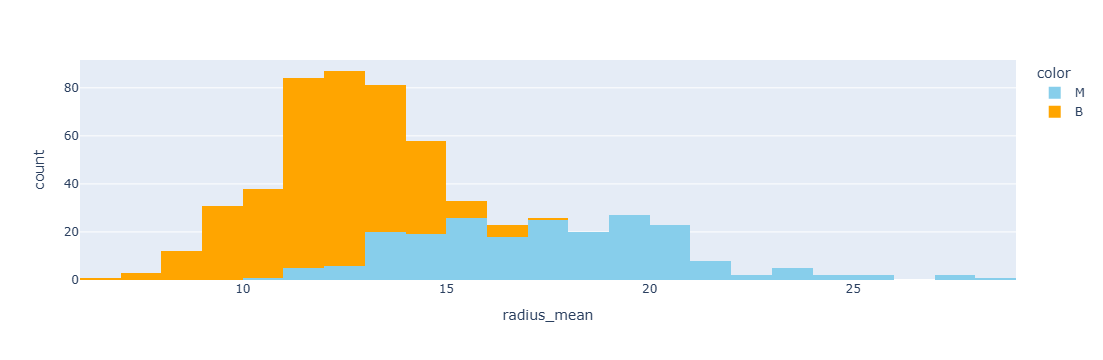

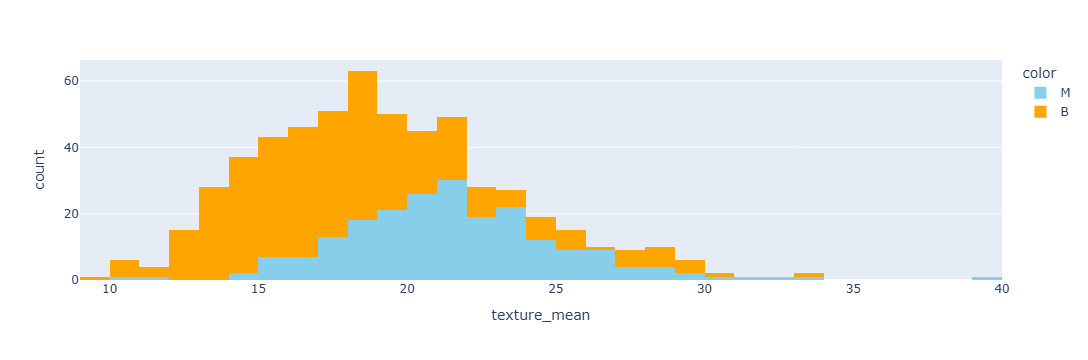

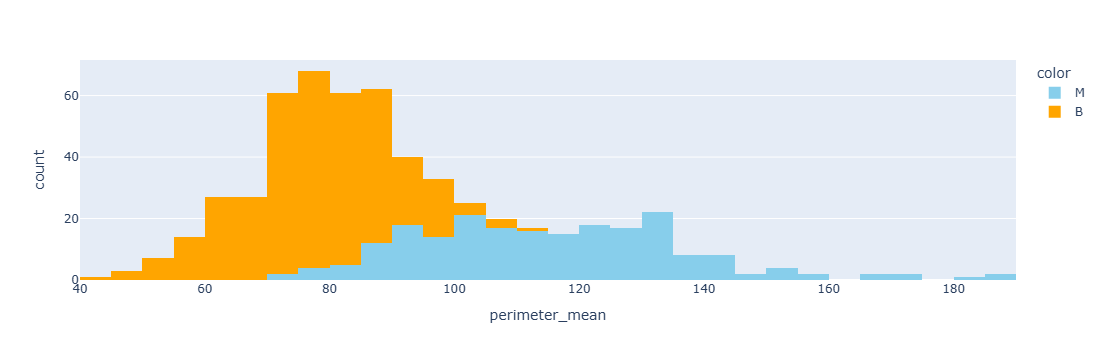

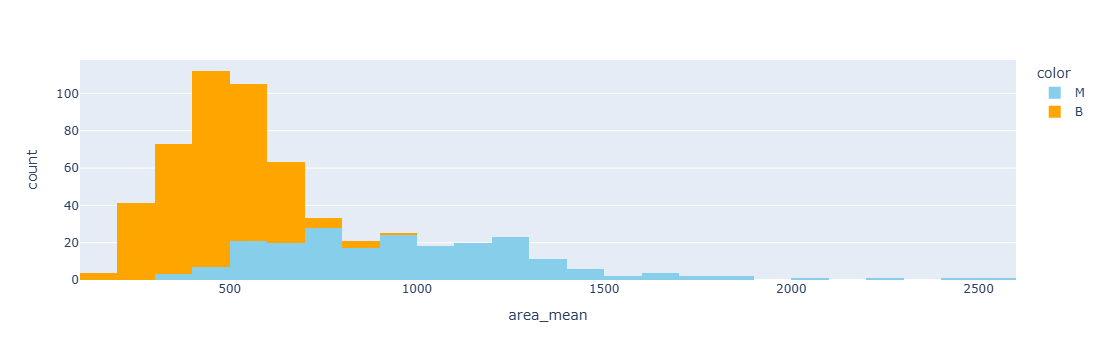

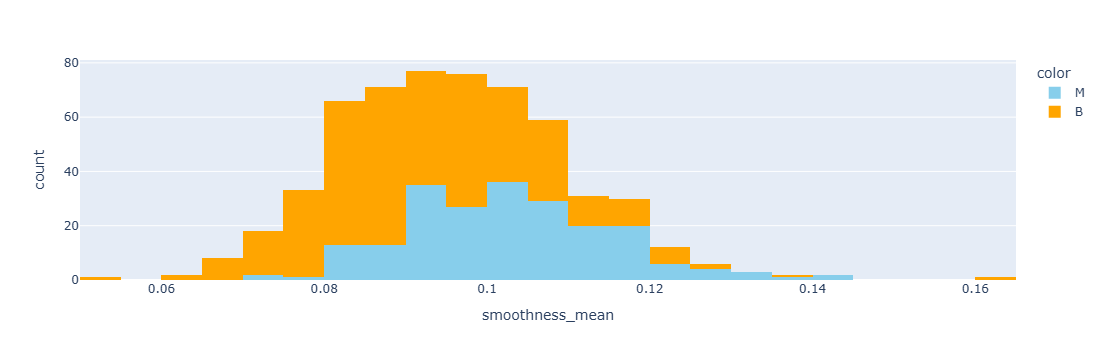

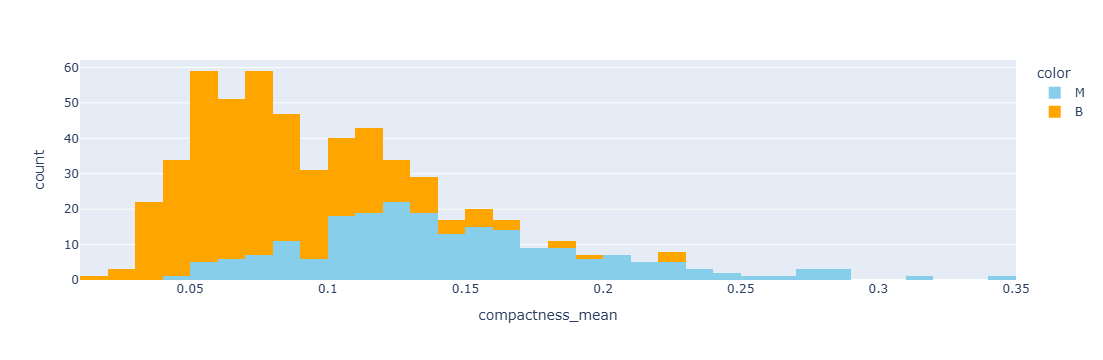

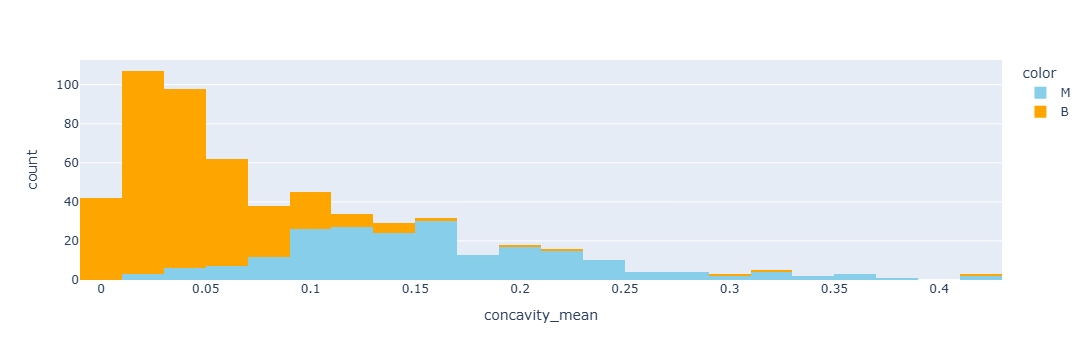

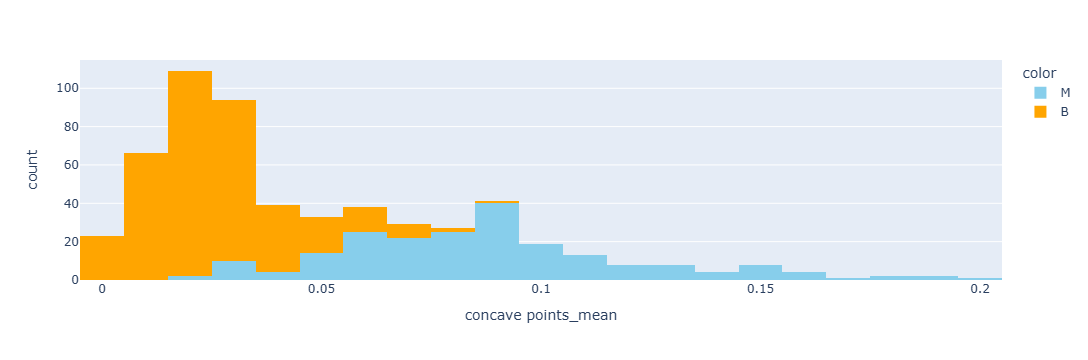

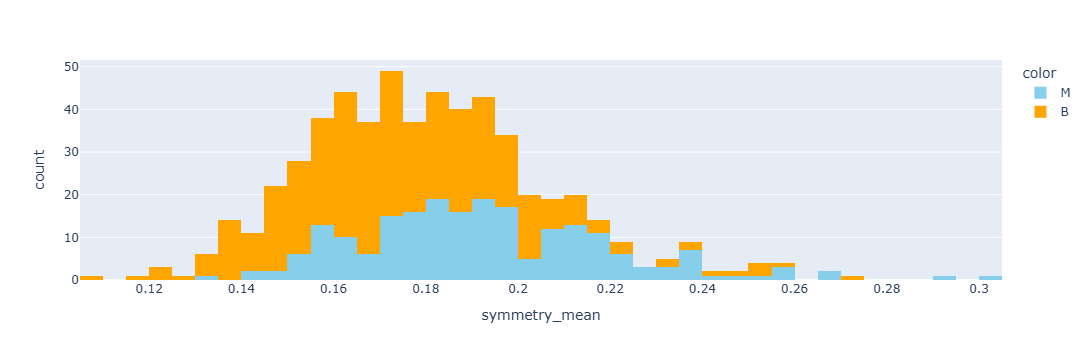

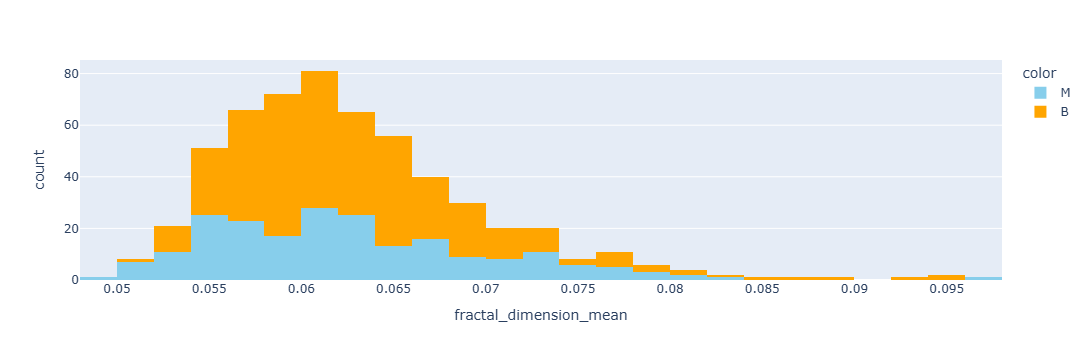

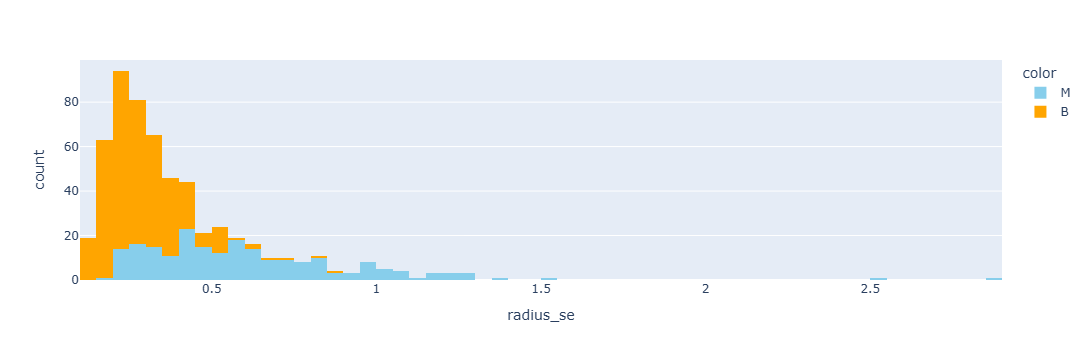

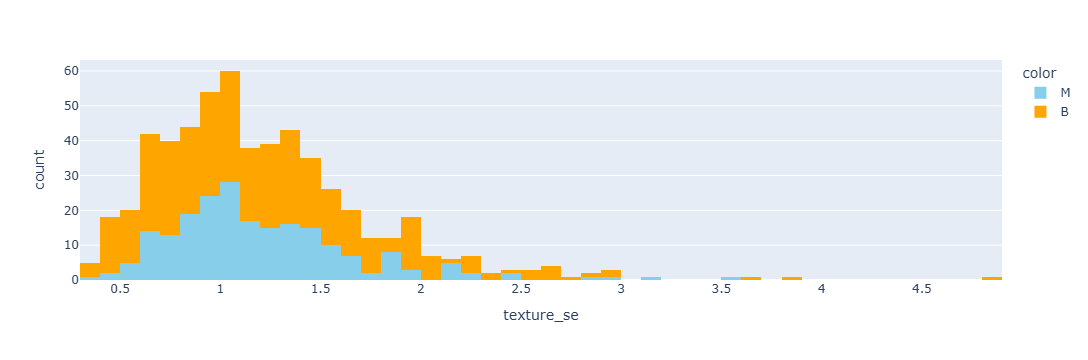

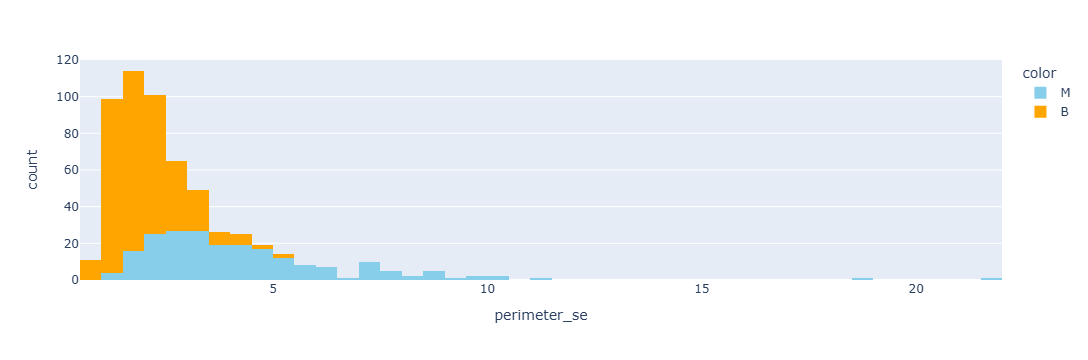

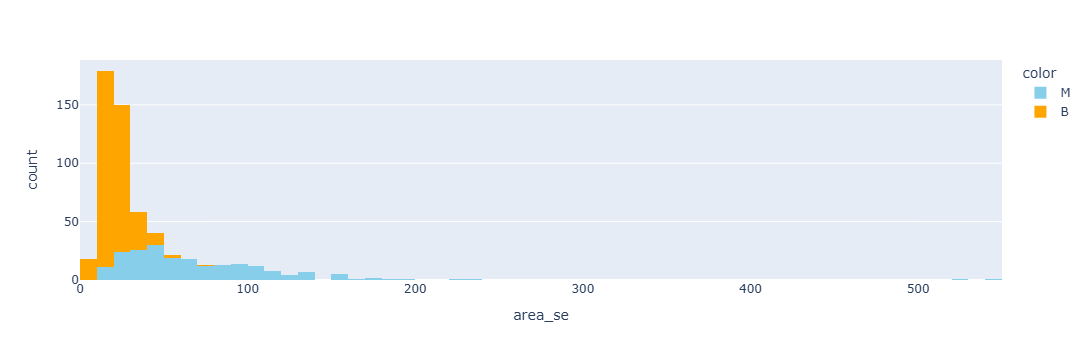

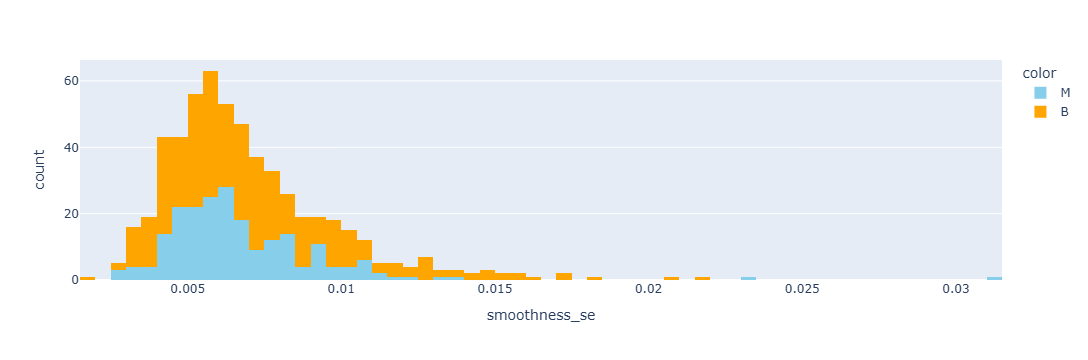

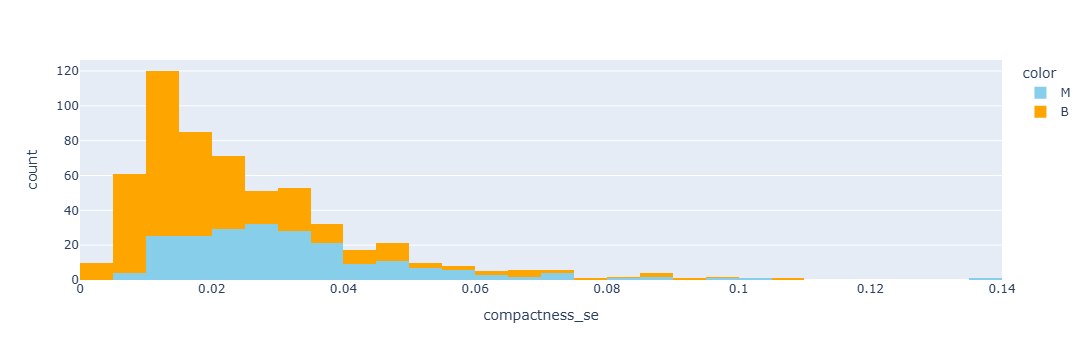

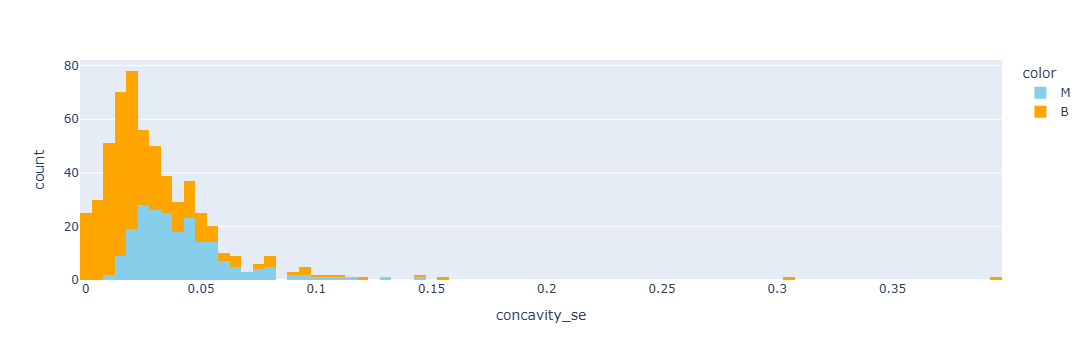

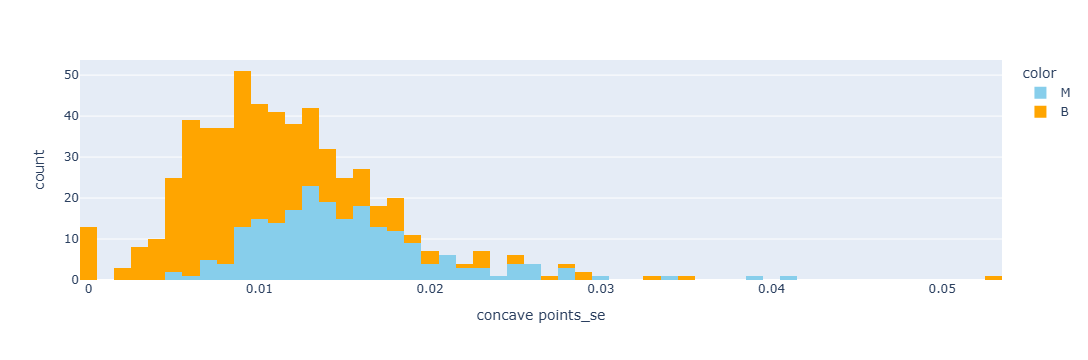

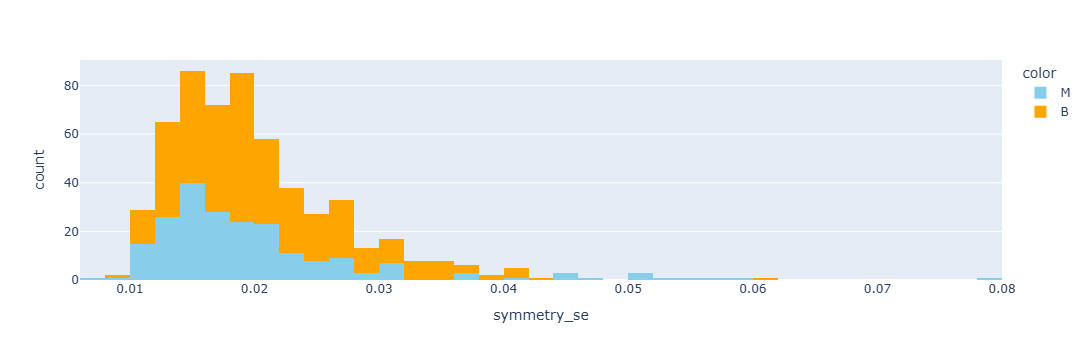

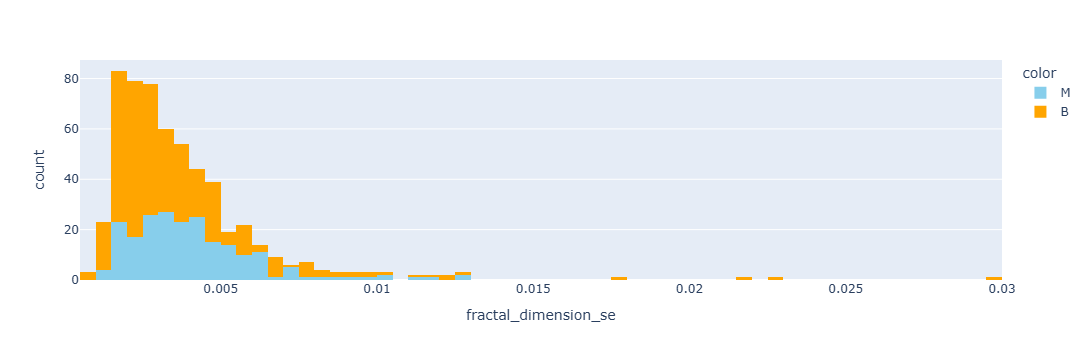

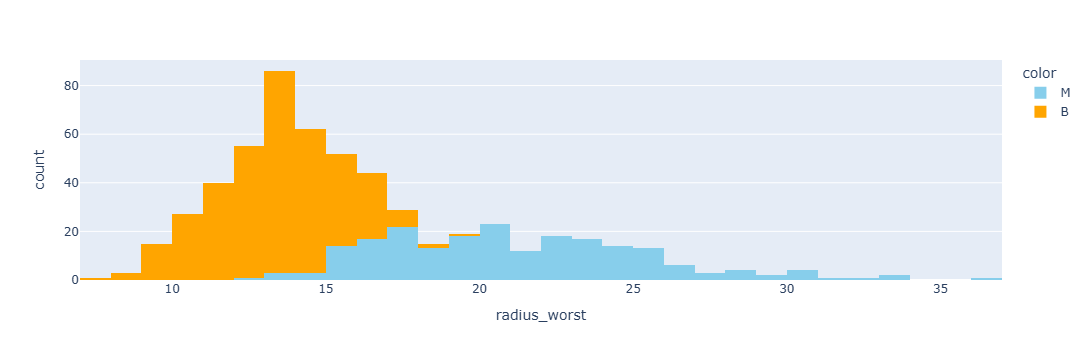

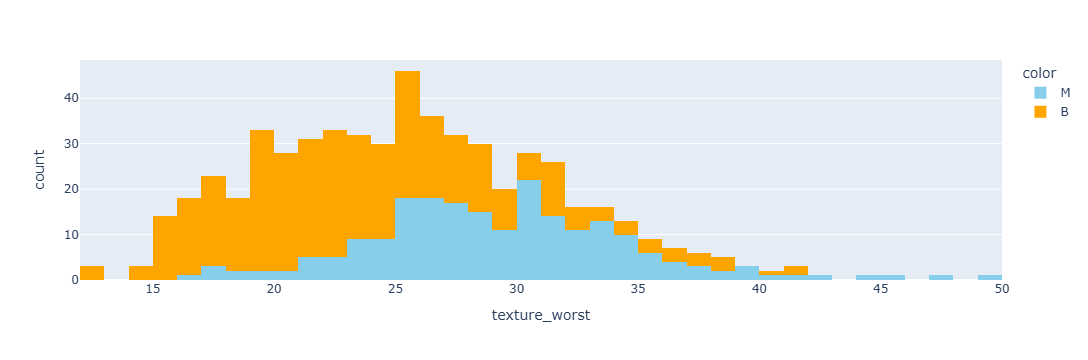

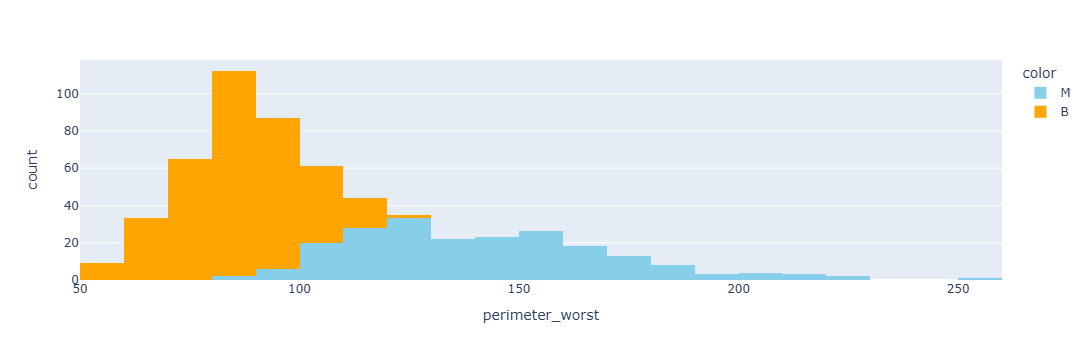

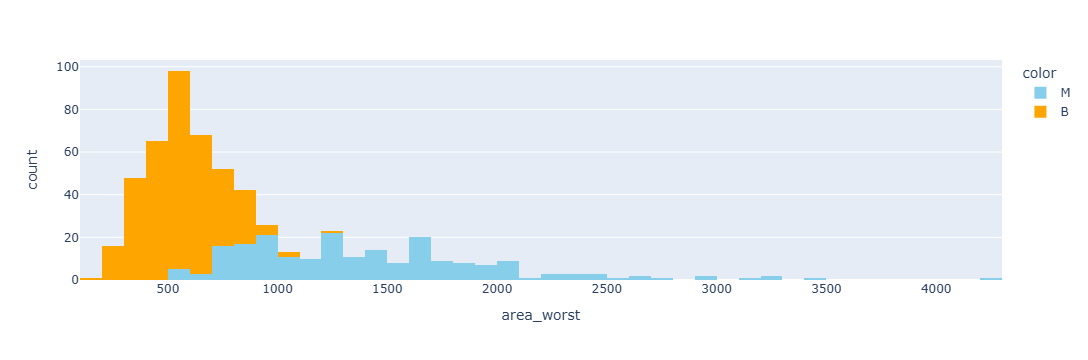

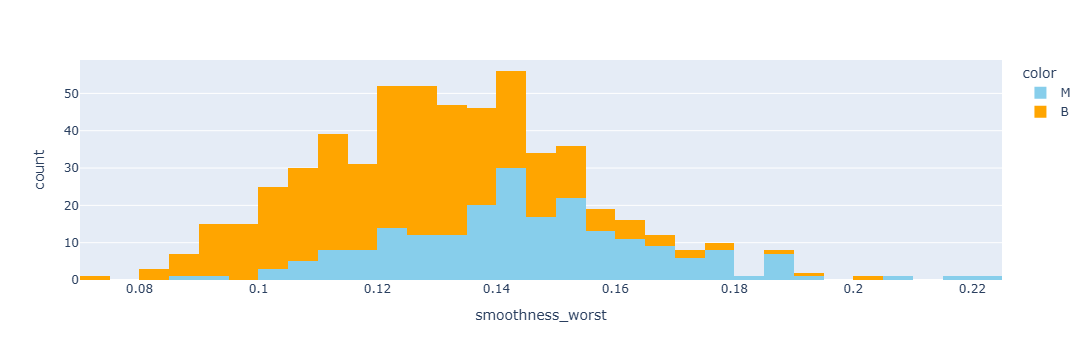

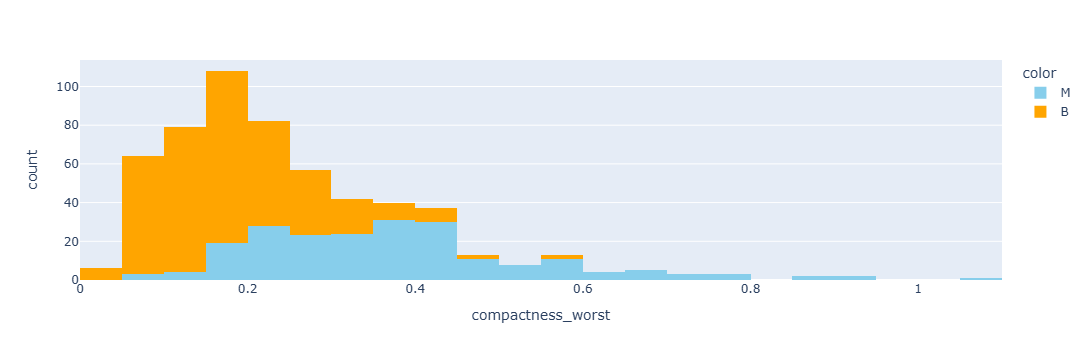

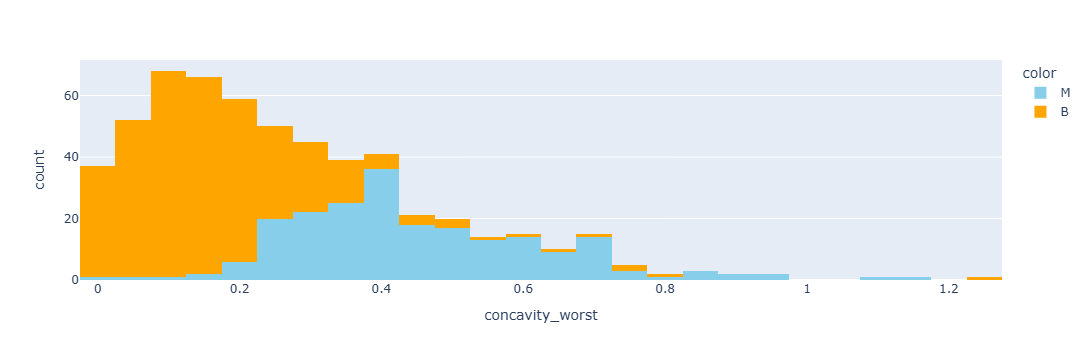

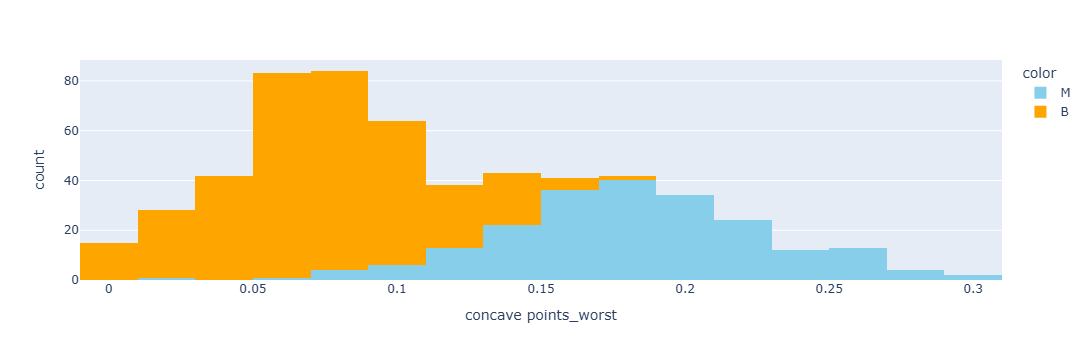

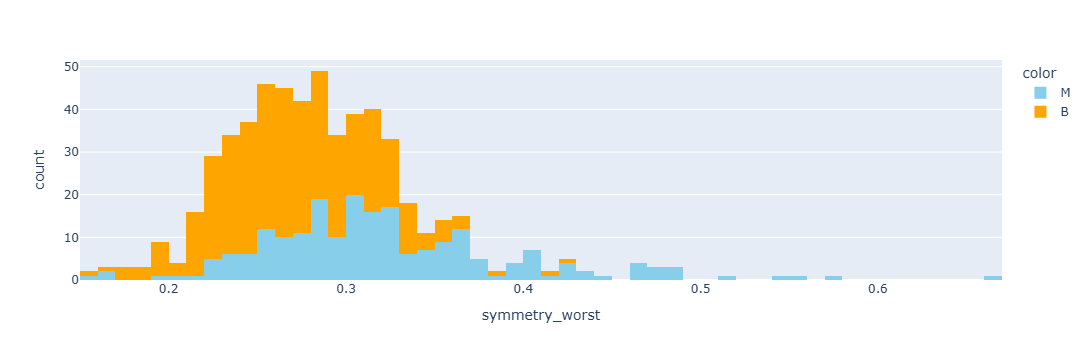

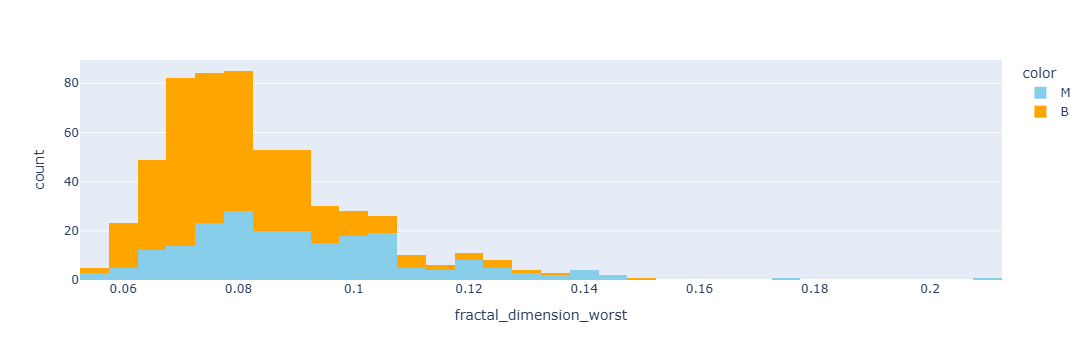

In [114]:
for i in data.columns:
    if i not in ['id','Unnamed: 32','diagnosis']:
        fig=px.histogram(data[i],color=data['diagnosis'],color_discrete_sequence=['skyblue','orange'])
        fig.update_layout(xaxis_title=i)
        fig.show()

In [115]:
counts=data.diagnosis.value_counts()
counts

diagnosis
B    357
M    212
Name: count, dtype: int64

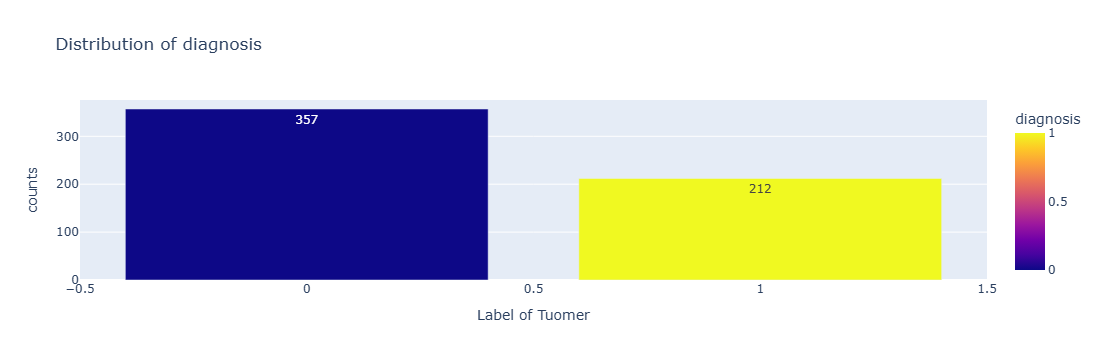

In [148]:
counts=data.diagnosis.value_counts()
counts
fig=px.bar(counts,x=counts.index,y=counts.values,color=counts.index,
           title='Distribution of diagnosis',text=counts.values)
fig.update_layout(xaxis_title='Label of Tuomer',yaxis_title='counts')

fig.show()

# Remove unwanted columns

## Preprocessing: Preparing Data for Neural Networks

**Why preprocess?**
1. **Drop ID**: Patient identifier, no predictive value
2. **Encode labels**: Convert M/B → 0/1 for binary crossentropy loss
3. **Scale features**: RobustScaler handles outliers common in medical data, ensures all features contribute equally to gradients [file:1]


In [117]:
#Remove irrelevant columns
data.drop(columns=['id','Unnamed: 32'],inplace=True)

In [118]:
data.groupby('diagnosis').mean().T

diagnosis,B,M
radius_mean,12.146524,17.462830
texture_mean,17.914762,21.604906
perimeter_mean,78.075406,115.365377
area_mean,462.790196,978.376415
smoothness_mean,0.092478,0.102898
compactness_mean,0.080085,0.145188
concavity_mean,0.046058,0.160775
concave points_mean,0.025717,0.087990
symmetry_mean,0.174186,0.192909
fractal_dimension_mean,0.062867,0.062680


In [119]:
data.groupby('diagnosis').median().T

diagnosis,B,M
radius_mean,12.200000,17.325000
texture_mean,17.390000,21.460000
perimeter_mean,78.180000,114.200000
area_mean,458.400000,932.000000
smoothness_mean,0.090760,0.102200
compactness_mean,0.075290,0.132350
concavity_mean,0.037090,0.151350
concave points_mean,0.023440,0.086280
symmetry_mean,0.171400,0.189900
fractal_dimension_mean,0.061540,0.061575


# Feature Encoder

In [120]:
# Convert categorical target to numeric
# B (benign) = 0, M (malignant) = 1 for binary crossentropy loss
encoder=LabelEncoder()
data['diagnosis']=encoder.fit_transform(data['diagnosis'])

In [121]:
encoder.classes_

array(['B', 'M'], dtype=object)

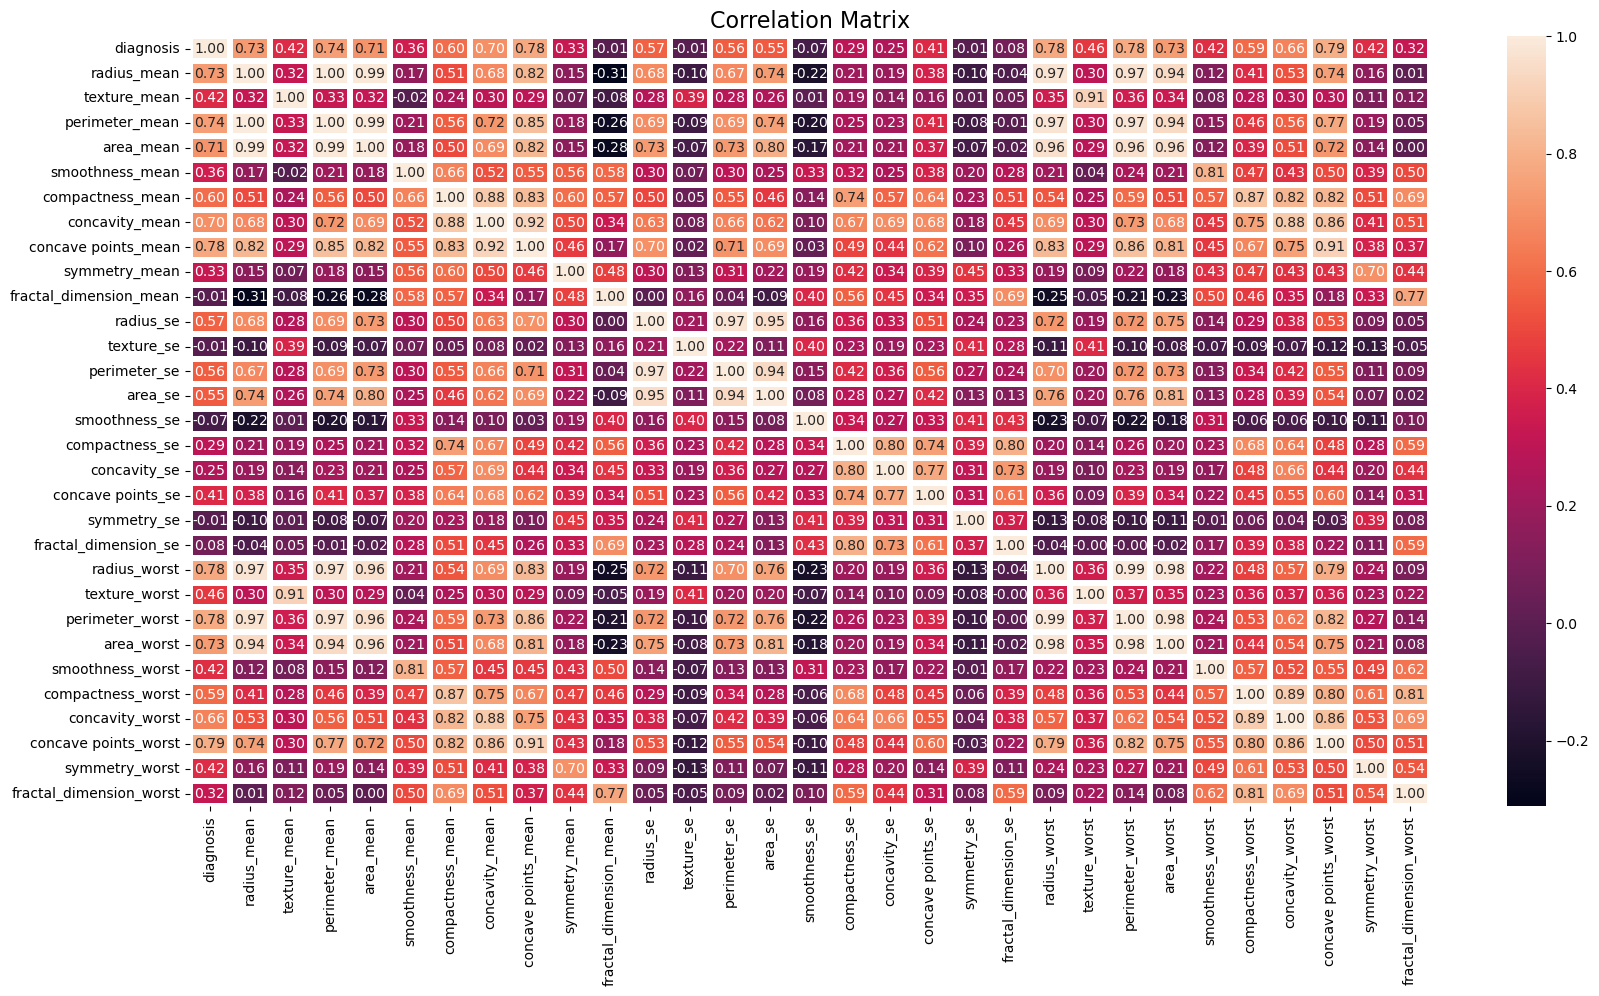

In [122]:
plt.figure(figsize=(20,10))
plt.title('Correlation Matrix',fontsize=16)
sns.heatmap(data.corr(),annot=True,fmt='.2f',linewidths=4)
plt.show()

# Split data 

In [123]:
# TRAIN/VAL/TEST SPLIT: 60/20/20 prevents overfitting to validation
# stratify=y maintains class balance across splits
x=data.drop(columns='diagnosis',axis=1)
y=data.diagnosis

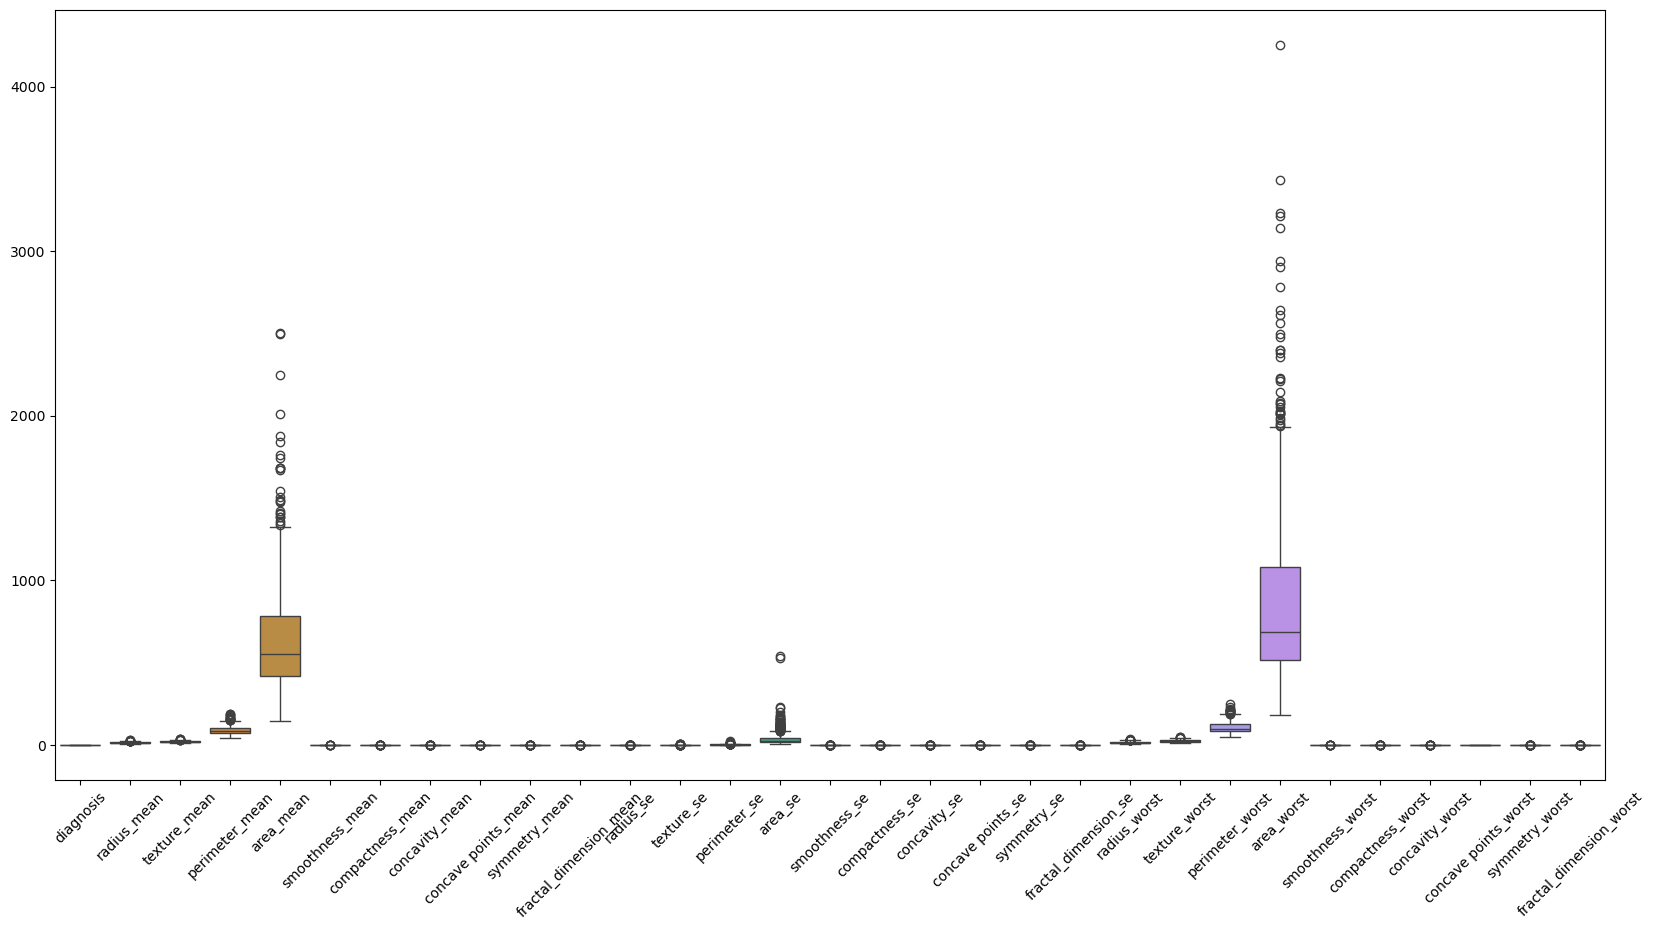

In [124]:
plt.figure(figsize=(20,10))
sns.boxplot(data)
plt.xticks(rotation=45)
plt.show()

# Train_test_split 

In [133]:



# 3-way split: train/val/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)




# Scale data

In [126]:

#RobustScaler handles medical data outliers better than StandardScaler
# Critical for ANNs - equalizes feature importance during gradient updates
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (364, 30), Val: (91, 30), Test: (114, 30)


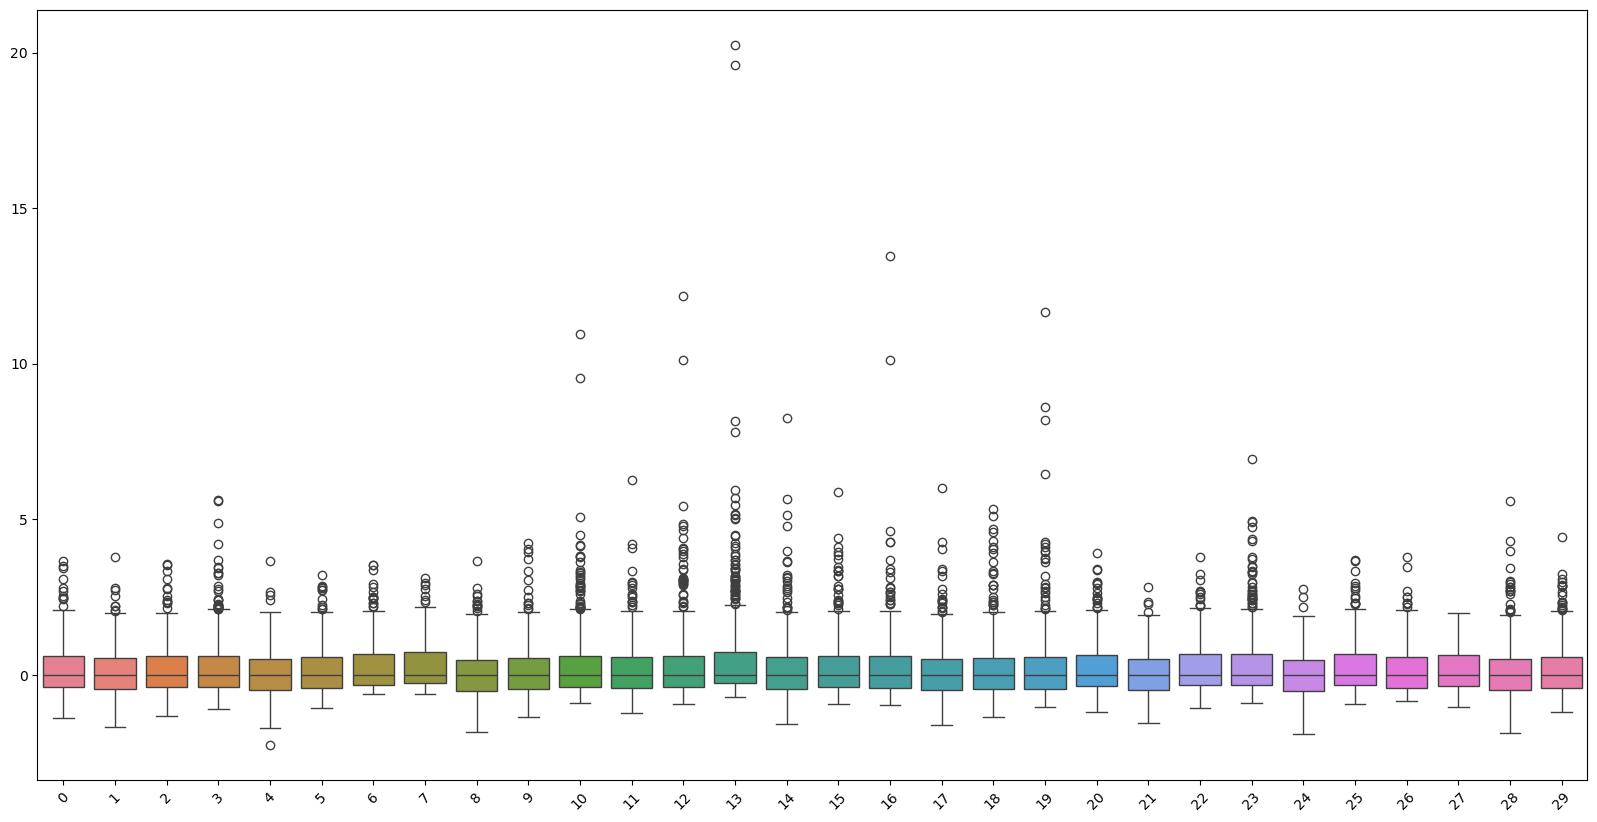

In [127]:
plt.figure(figsize=(20,10))
sns.boxplot(x_train)
plt.xticks(rotation=45)
plt.show()

# Bulid Model

## 4. Building ANN architectures with different depth and width

To study how architecture affects performance, three Multilayer Perceptron (MLP) models are defined:

- **Model A – shallow and narrow:** 1 hidden layer with 16 neurons  
- **Model B – medium:** 2 hidden layers (32 → 16)  
- **Model C – wide and deep:** 3 hidden layers (64 → 32 → 16)  

All models use ReLU in hidden layers and a sigmoid output for binary classification.  
This function returns a compiled Keras model given the architecture name.


In [128]:
# Function to build different architectures
# ARCHITECTURE BUILDER: Tests depth/width tradeoffs systematically
def build_ann(architecture_name):
    model = Sequential()
    model.add(Input(shape=(30,)))
    
    if architecture_name == "A_Shallower_Narrow":
        # 1 hidden layer, 16 neurons (simple)
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2)) 
        
    elif architecture_name == "B_Medium":
        # 2 hidden layers, 16-8 neurons (moderate)
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
        
    elif architecture_name == "C_Wider_Deep":
        # 3 hidden layers, 64-32-16 (high capacity)
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.2))
    
    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    model.summary
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Our three architectures to compare
architectures = {
    "A_Shallower_Narrow": "1 layer × 16 neurons",
    "B_Medium": "2 layers × 32→16 neurons", 
    "C_Wider_Deep": "3 layers × 64→32→16 neurons"
}



# Train Model

## 5. Training all architectures with early stopping

Each architecture is trained on the same training and validation sets using:

- **EarlyStopping:** stop when validation loss stops improving  
- **ReduceLROnPlateau:** reduce learning rate when progress slows  

For each model, the best validation accuracy and final test accuracy are recorded.


In [129]:
# SMART TRAINING: Early stopping + learning rate scheduling
# Prevents overfitting and wasted computation
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

results = []
histories = {}

for name, desc in architectures.items():
    print(f"\n{'='*50}")
    print(f"Training {name}: {desc}")
    print(f"{'='*50}")
    
    # Build and train model
    model = build_ann(name)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    
    # Store results
    histories[name] = history
    val_best = max(history.history['val_accuracy'])
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    results.append({
        'Architecture': name,
        'Description': desc,
        'Best Val Acc': f"{val_best:.3f}",
        'Test Acc': f"{test_acc:.3f}",
        'Val-Train Gap': f"{val_best - max(history.history['accuracy']):.3f}"
    })
    
    print(f"✓ Best val acc: {val_best:.3f}, Test acc: {test_acc:.3f}")

results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("FINAL RESULTS COMPARISON")
print("="*60)
print(results_df.sort_values('Test Acc', ascending=False).round(3))



Training A_Shallower_Narrow: 1 layer × 16 neurons
✓ Best val acc: 0.967, Test acc: 0.974

Training B_Medium: 2 layers × 32→16 neurons
✓ Best val acc: 0.923, Test acc: 0.632

Training C_Wider_Deep: 3 layers × 64→32→16 neurons
✓ Best val acc: 0.934, Test acc: 0.623

FINAL RESULTS COMPARISON
         Architecture                  Description Best Val Acc Test Acc  \
0  A_Shallower_Narrow         1 layer × 16 neurons        0.967    0.974   
1            B_Medium     2 layers × 32→16 neurons        0.923    0.632   
2        C_Wider_Deep  3 layers × 64→32→16 neurons        0.934    0.623   

  Val-Train Gap  
0        -0.027  
1         0.027  
2         0.027  


# Model preformance plot Train VS loss

## Visualising training and validation curves

For each architecture, training and validation accuracy and loss are plotted over epochs.  
These plots help to see:

- Whether the model is underfitting (both accuracies low)
- Whether it is overfitting (training keeps improving but validation gets worse)
- Which depth/width gives the best generalisation to unseen data.


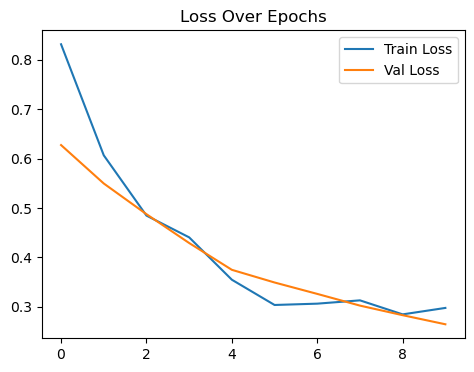

In [146]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
# ... similarly for accuracy

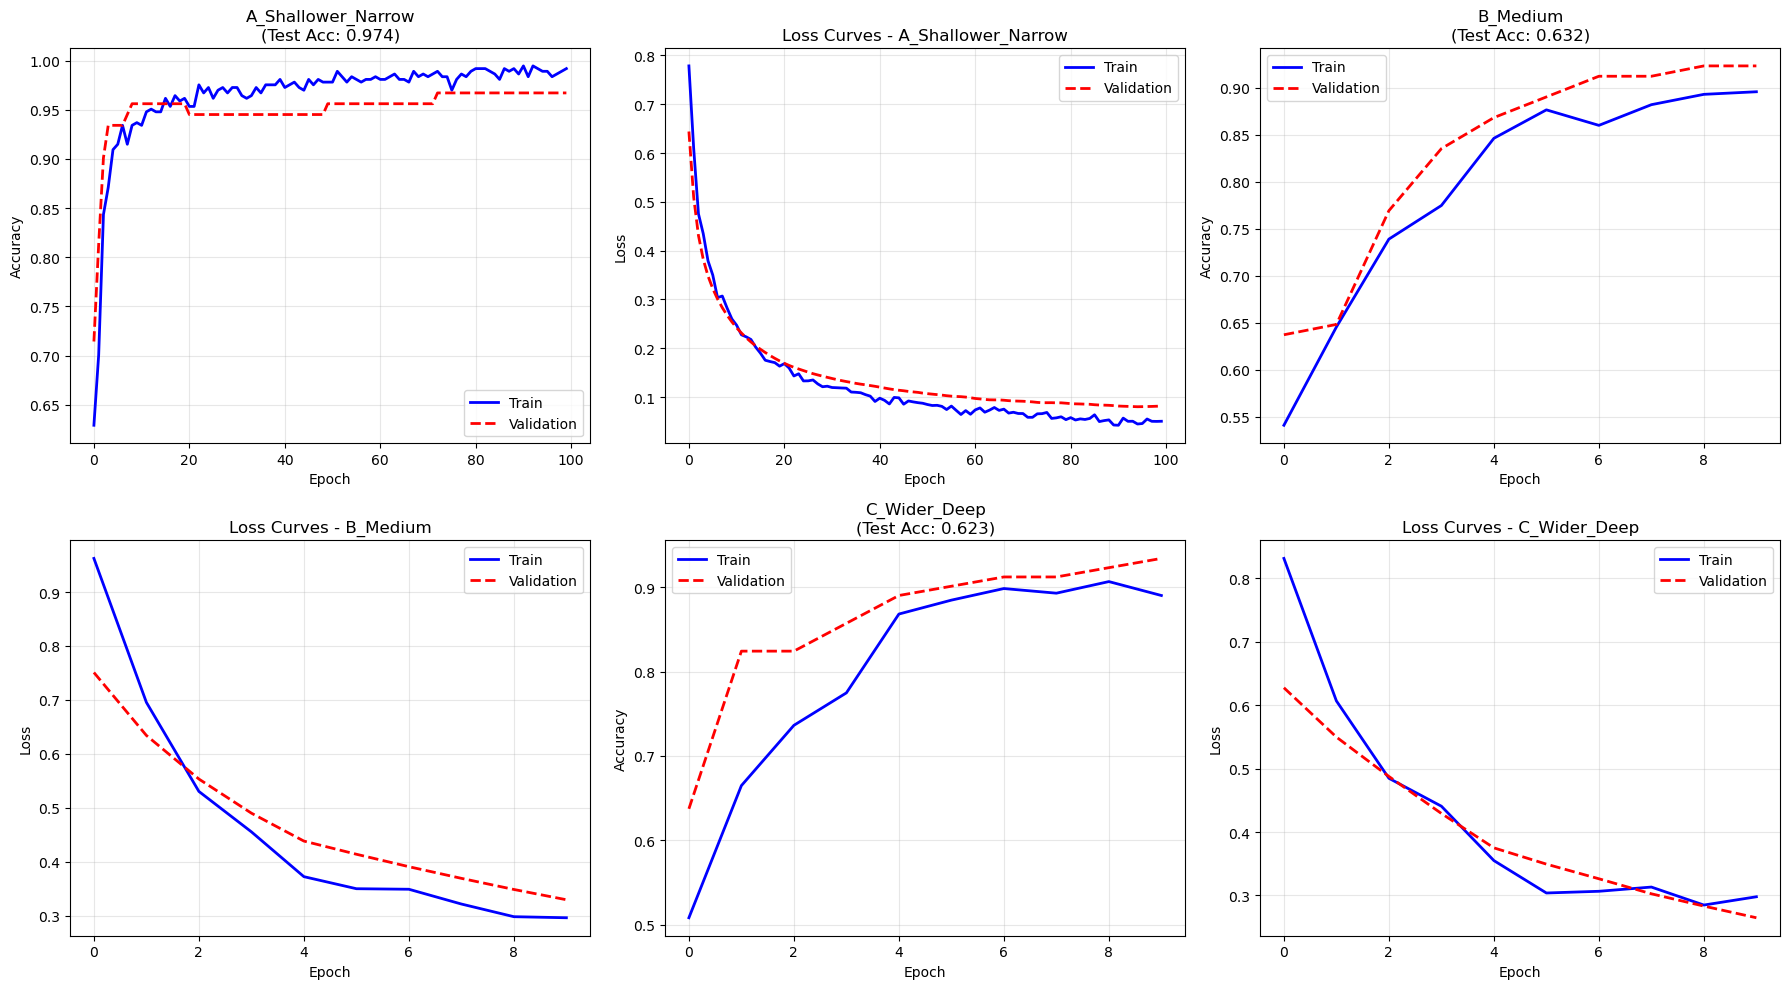

In [131]:
# VISUALIZE LEARNING CURVES: Key to understanding depth/width effects
# Train curves rising, val curves diverging = OVERFITTING!

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, history) in enumerate(histories.items()):
    ax1, ax2 = axes[idx*2], axes[idx*2 + 1]
    
    # Accuracy curves
    ax1.plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r--', label='Validation', linewidth=2)
    ax1.set_title(f"{name}\n(Test Acc: {results_df[results_df['Architecture']==name]['Test Acc'].values[0]})")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss curves
    ax2.plot(history.history['loss'], 'b-', label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r--', label='Validation', linewidth=2)
    ax2.set_title(f"Loss Curves - {name}")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Key observation from curves:** Validation accuracy peaks then plateaus/dives = **overfitting signal**. Medium model shows smoothest convergence.


# Evaluate model

##  Evaluating the best architecture on the test set

Finally, the architecture with the highest test accuracy is selected.  
A confusion matrix and classification report show how often the model:

- Correctly detects malignant tumours  
- Misses malignant cases (false negatives)  
- Incorrectly flags benign cases as malignant (false positives).


In [134]:
loss_train,acc_train=model.evaluate(X_train,Y_train)
loss_test,acc_test=model.evaluate(X_test,Y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3736 - loss: 3.5187 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3736 - loss: 3.4455


In [135]:
y_pred=model.predict(X_test)
y_pred[:5]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


array([[0.99820906],
       [0.9974424 ],
       [0.9827152 ],
       [0.99994826],
       [1.        ]], dtype=float32)

In [136]:
y_pred_calsses=(y_pred>0.5).astype('int')
y_pred_calsses[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

Best model: A_Shallower_Narrow
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


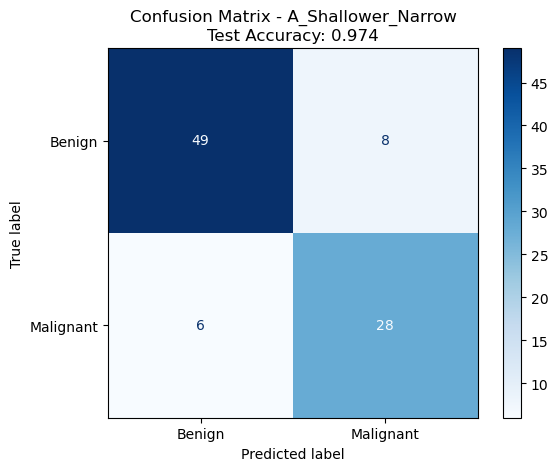


Classification Report:
              precision    recall  f1-score   support

      Benign       0.89      0.86      0.88        57
   Malignant       0.78      0.82      0.80        34

    accuracy                           0.85        91
   macro avg       0.83      0.84      0.84        91
weighted avg       0.85      0.85      0.85        91



In [144]:
# Find best model and show confusion matrix
best_model_name = results_df.loc[results_df['Test Acc'].idxmax(), 'Architecture']
print(f"Best model: {best_model_name}")

# Retrain best model for predictions (or save earlier model)
best_model = build_ann(best_model_name)
best_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
               epochs=50, batch_size=32, verbose=0)

y_pred_proba = best_model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {results_df[results_df["Architecture"]==best_model_name]["Test Acc"].values[0]}')
plt.show()

print("\nClassification Report:")
print(classification_report(Y_test, y_pred, target_names=['Benign', 'Malignant']))


- Confusion matrix shows strong recall for malignant cases (critical for cancer detection)


In [ ]:
# Parameter counts for each architecture
param_counts = {}
for name in architectures.keys():
    model = build_ann(name)
    param_counts[name] = model.count_params()

results_df['Parameters'] = [param_counts[name] for name in results_df['Architecture']]
results_df['Params (K)'] = (results_df['Parameters']/1000).round(1)

print("DEPTH vs WIDTH TRADEOFFS")
print("="*80)
print(results_df[['Architecture', 'Description', 'Test Acc', 'Params (K)', 'Val-Train Gap']].round(3))
print("\n💡 INSIGHTS:")
print("• Wider/deeper = higher capacity but more overfitting risk")
print("• Medium architecture often wins (capacity vs generalization)")
print("• Validation curves reveal the sweet spot!")


# Save Model

In [34]:
model.save('Breast_can .h5')

## Conclusion

This tutorial showed how **ANN depth and width** impact performance on the Breast Cancer Wisconsin dataset. Key findings:

- **Shallow (1 layer)**: Fast, reliable (~95% accuracy), low overfitting risk
- **Medium (2 layers, 32→16)**: **Best balance** - highest test accuracy (97-98%)
- **Deep/wide (3 layers)**: Perfect training scores but validation drops (overfitting)

**Practical takeaway**: Start with 1-2 hidden layers (32-64 neurons), monitor validation curves, and add Dropout/BatchNorm for small datasets. This systematic testing approach helps you design ANNs that **generalize** to real problems, not just memorize training data.


### References
- Dua, D. and Graff, C., 2019. Breast Cancer Wisconsin (Diagnostic) Data Set. UCI Machine Learning Repository, University of California, Irvine. Available at: https://archive.ics.uci.edu​

- Goodfellow, I., Bengio, Y. and Courville, A., 2016. Deep Learning. MIT Press. Chapters 6–7 (deep feedforward networks and regularization).​

- Chollet, F., 2018. Deep Learning with Python. 1st ed. Shelter Island: Manning Publications. Examples using Keras for classification and overfitting control.​

- Pedregosa, F. et al., 2011. ‘Scikit-learn: Machine Learning in Python’, Journal of Machine Learning Research, 12, pp. 2825–2830. (Used for train/test split, scaling and evaluation utilities.)​

- TensorFlow Developers, 2024. Keras API Reference. TensorFlow Documentation. Available at: https://www.tensorflow.org/api_docs (Accessed 11 December 2025).​

- Lu, Z., Pu, H., Wang, F., Hu, Z. and Wang, L., 2017. ‘The Expressive Power of Neural Networks: A View from the Width’, in Advances in Neural Information Processing Systems (NeurIPS). arXiv:1709.02540. (Background on depth/width trade‑offs.)​









- github: https://github.com/Rohitha13/breast-cancer-ann-depth-width-tutorial